## GAN:
1. Discriminator
2. Generator

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms     # for augmentation, converting to tensors, resize, etc...
import matplotlib.pyplot as plt
import numpy as np

# 1. Data preparation:

Pull a simple dataset. (MNIST)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.56MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.89MB/s]


### Visualization:

transform operation gareko hunale, de-transform garera matra visualize garnu paryo

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap = 'gray')
    plt.show()

In [ ]:
def show_grid(images):  # for visualization in grid
  img_grid = torchvision.utils.make_grid(images, nrow = 8)
  imshow(img_grid)

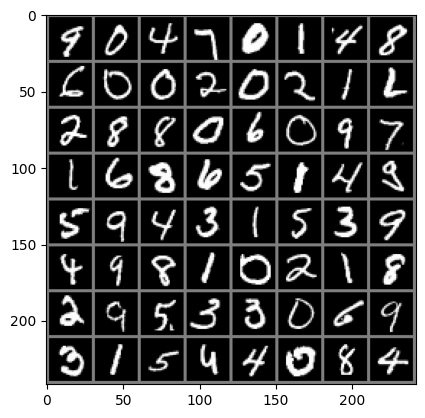

In [ ]:
trainloader_for_vis = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
dataiter = iter(trainloader_for_vis)
images, labels = next(dataiter)
show_grid(images)

In [ ]:
shape = images.shape
print("Shape:", shape)

Shape: torch.Size([64, 1, 28, 28])


# Discriminator model

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.flatten = nn.Flatten()
    self.classifier = nn.Sequential(
        nn.Linear(28*28, 1024),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(1024, 512),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(512, 256),
        nn.LeakyReLU(0.2),
        nn.Dropout(0.3),

        nn.Linear(256, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    x = self.flatten(x)
    x = self.classifier(x)
    return x

# Generator Network:

In [ ]:
class Generator(nn.Module):
  def __init__(self, latent_dim = 100):
    super(Generator, self).__init__()
    self.mlp = nn.Sequential(
        nn.Linear(latent_dim, 256),
        nn.LeakyReLU(0.2),

        nn.Linear(256, 512),
        nn.LeakyReLU(0.2),

        nn.Linear(512, 1024),
        nn.LeakyReLU(0.2),

        nn.Linear(1024, 28*28),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.mlp(x)
    x = x.reshape(x.size(0), 1, 28, 28)
    return x

# Training:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
latent_dim = 100
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

In [ ]:
# defining hyperparameters: loss, optimizer,  epoch, etc...
criterion = nn.BCELoss()
num_epochs = 10
optimizer_G = optim.Adam(generator.parameters(), lr = 0.001)   # parameters of model(object)
optimizer_D = optim.Adam(discriminator.parameters(), lr = 0.001)

In [ ]:
discriminator_loss = []
generator_loss = []

main logic is as follows:

In [ ]:
for epoch in range(num_epochs):
  d_epoch_loss = 0
  g_epoch_loss = 0
  for i, (images, _) in enumerate(trainloader):
    batch_size = images.size(0)
    images = images.to(device)

    # create labels for training
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # _____________________________________________________________#

    outputs = discriminator(images)   # (real image) forward pass to d
    d_real_data_loss = criterion(outputs, real_labels)  # loss computation
    real_score = outputs

    z = torch.randn(batch_size, latent_dim).to(device)    # noise
    fake_images = generator(z)   # forward pass to g
    outputs = discriminator(fake_images)  # (fake image) forward pass to d
    d_fake_data_loss = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_real_data_loss + d_fake_data_loss
    d_epoch_loss +=d_loss.item()

    discriminator.zero_grad()
    d_loss.backward()               # gradient for backpass
    optimizer_D.step()              # backpass

    # _____________________________________________________________#

    z = torch.randn(batch_size, latent_dim).to(device)   # noise
    fake_images = generator(z)   # forward pass to g
    outputs = discriminator(fake_images)   # (fake image)forward pass to d
    g_loss = criterion(outputs, real_labels)          ## compare discriminator's output (detects fake or real) with real

    g_epoch_loss += g_loss.item()
    optimizer_G.zero_grad()
    g_loss.backward()   # gradient
    optimizer_G.step()  # backpass

    # _____________________________________________________________#

    if (i+1) % 10 == 0:
      print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.4f}, D(G(z)): {fake_score.mean().item():.4f}')

  generator_loss.append(g_epoch_loss / len(trainloader))
  discriminator_loss.append(d_epoch_loss / len(trainloader))

  if (epoch+1) % 10 == 0:
    # Detach the tensor from the computation graph before converting to NumPy
    fake_images_np = fake_images.detach().cpu().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.size[0], 1, 28, 28)


    fig, ax = plt.subplots(1, 10, figsize = (10, 1))
    for i in range(10):
      ax[i].imshow(fake_images_np[i][0], cmap = 'gray')
      ax[i].axis('off')
    plt.show()

Epoch [1/10], Step [10/938], d_loss: 1.3741, g_loss: 0.5088, D(x): 0.6187, D(G(z)): 0.5902
Epoch [1/10], Step [20/938], d_loss: 1.5663, g_loss: 3.3412, D(x): 0.2970, D(G(z)): 0.1378
Epoch [1/10], Step [30/938], d_loss: 0.0064, g_loss: 13.3912, D(x): 0.9940, D(G(z)): 0.0004
Epoch [1/10], Step [40/938], d_loss: 1.2470, g_loss: 1.6988, D(x): 0.4624, D(G(z)): 0.3404
Epoch [1/10], Step [50/938], d_loss: 0.2853, g_loss: 5.6080, D(x): 0.8110, D(G(z)): 0.0494
Epoch [1/10], Step [60/938], d_loss: 8.0382, g_loss: 0.0227, D(x): 0.5893, D(G(z)): 0.9981
Epoch [1/10], Step [70/938], d_loss: 0.9524, g_loss: 3.3661, D(x): 0.5847, D(G(z)): 0.2983
Epoch [1/10], Step [80/938], d_loss: 0.0220, g_loss: 5.5831, D(x): 0.9988, D(G(z)): 0.0202
Epoch [1/10], Step [90/938], d_loss: 2.5240, g_loss: 17.6932, D(x): 0.1462, D(G(z)): 0.0028
Epoch [1/10], Step [100/938], d_loss: 0.0000, g_loss: 35.4976, D(x): 1.0000, D(G(z)): 0.0000
Epoch [1/10], Step [110/938], d_loss: 0.0000, g_loss: 44.0486, D(x): 1.0000, D(G(z)): 

TypeError: 'int' object is not subscriptable

In [ ]:
torch.save(generator, 'generator.pt')
torch.save(discriminator, 'discriminator.pt')

Plot the curves

In [ ]:
import matplotlib.pyplot as plt

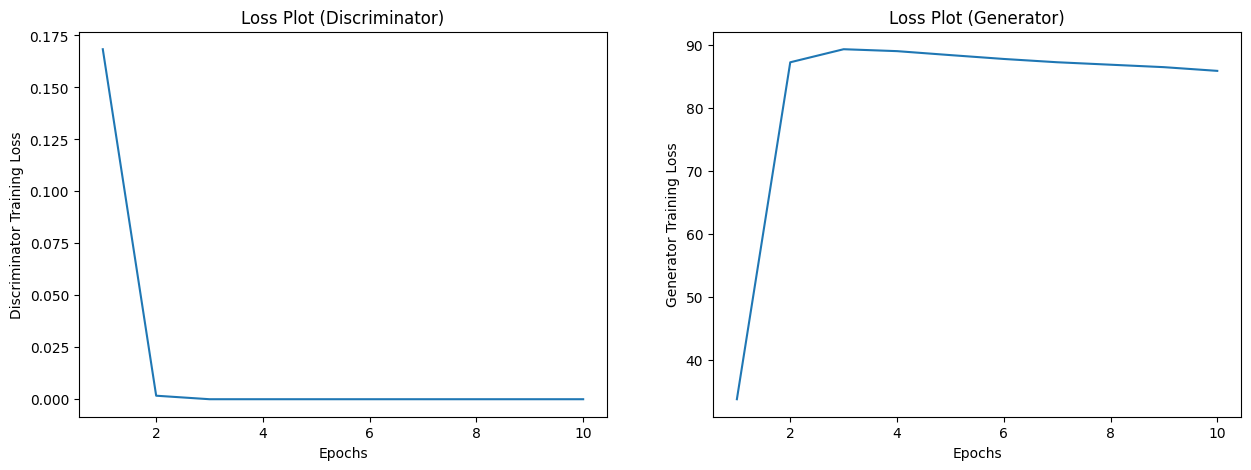

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Loss Plot (Discriminator)")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot (Generator)")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

# Evaluate

In [ ]:
generator = torch.load('generator.pt')
discriminator = torch.load('discriminator.pt')

num_samples = 10
input_noise = torch.randn(num_samples, latent_dim.to(device))

generated_samples = generator(input_noise)    # forward pass
generated_samples_np = generated_samples.detach().cpu().numpy()